Flight delay is a costly problem to consumers, airlines, and industrial experts. Delays provoke complaints from passengers, create high costs to airlines, and result in difficulties for airport operations. It is therefore important for the Federal Aviation Administration (FAA) to understand the causes of delay as a means to reduce the total cost that delays can cause.

Factors that cause flight delays include weather at the origin airport, congestion at the origin airport, and air traffic management (ATM) decisions such as Ground Delay Programs (GDP). Each component interacts with other components in complex ways, which is why flight delays are an inherently stochastic phenomenon. Simply examining the marginal distributions of such factor does not truly reveal the effects that such factors have or the relationship between any two of such factors.

Here, we will perform a case study of the use of Bayesian networks to model the relationship between different components of aircraft delay and the causal factors that affect delays. Bayesian networks allow us to simultaneously examine multiple components of delay and their relationships in a single analysis, an advantage that the use of Bayesian networks has over linear and nonlinear regression models. Moreover, Bayesian network models provide not only just predictions of future delays that incorporate the interrelationships among causal factors, but also a means of assessing the ultimate influence each causal factors has on arrival delay.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time
import calendar
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def filterRoutes(df):
    '''
    filter df to contain delayed fligths from SFO to PHL routes only.
    '''
    df = df[(df['ORIGIN'] == 'SFO') & (df['DEST'] == 'PHL') & (df['ARR_DELAY'] > 0)]
    df = df.reset_index()
    return df.drop(['index','YEAR','ORIGIN','DEST', 'UNIQUE_CARRIER','DEP_TIME','DEP_TIME_BLK','DEP_DELAY_GROUP', 'DEP_DELAY_NEW', \
                    'DEP_DEL15','WHEELS_OFF','WHEELS_ON','ARR_DELAY','ARR_DELAY_NEW','Unnamed: 29'],axis=1)

def dateColumns(df):
    dates = [str(d).replace('/','') for d in list(df['Date'])]
    dates = [time.strptime(d,'%m%d%Y') for d in dates]
    df['MONTH'] = [d.tm_mon for d in dates]
    df['DAY'] = [d.tm_mday for d in dates]

# Read and Merge Data

Read data and filter for SFO to PHL routes.

In [3]:
# read data and filter for relevant delayed flights
jan_df = filterRoutes(pd.read_csv('./month/jan2017.csv'))
feb_df = filterRoutes(pd.read_csv('./month/feb2017.csv'))
mar_df = filterRoutes(pd.read_csv('./month/mar2017.csv'))
apr_df = filterRoutes(pd.read_csv('./month/apr2017.csv'))
may_df = filterRoutes(pd.read_csv('./month/may2017.csv'))
jun_df = filterRoutes(pd.read_csv('./month/jun2017.csv'))
jul_df = filterRoutes(pd.read_csv('./month/jul2017.csv'))
aug_df = filterRoutes(pd.read_csv('./month/aug2017.csv'))
sep_df = filterRoutes(pd.read_csv('./month/sep2017.csv'))
oct_df = filterRoutes(pd.read_csv('./month/oct2017.csv'))
nov_df = filterRoutes(pd.read_csv('./month/nov2017.csv'))
dec_df = filterRoutes(pd.read_csv('./month/dec2017.csv'))

# concatenate dataframes by quarter
flights_df = pd.concat([jan_df, feb_df,mar_df,apr_df, may_df, jun_df, jul_df, aug_df, sep_df, oct_df, nov_df, dec_df])

# keep hour information from CRS but not minutes
flights_df['CRS_DEP_TIME'] = flights_df['CRS_DEP_TIME'] // 100
flights_df['CRS_ARR_TIME'] = flights_df['CRS_ARR_TIME'] // 100

Read in airport data `ASPM : Airport Analysis : Delayed Flights Report'

In [4]:
airports_df = pd.read_csv('./faa-aspm/airports.csv').dropna(axis=0,how='all')

# split Date into MONTH and DAY
airports_df['Facility'] = airports_df['Facility'].str.strip()
dateColumns(airports_df)
airports_df = airports_df.drop(['Date','% DelayedGateDepartures','% DelayedGateArrivals','Date'],axis=1)
airports_df = airports_df.drop(['DeparturesFor MetricComputation','ArrivalsFor MetricComputation','AverageMinutesOf DelayPer DelayedGateDeparture','AverageMinutesOf DelayPer DelayedGateArrival'],axis=1)

# find departure and arrival informations at airport at time of departure/arrival
# SFO (departure)
flights_SFO_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'],\
                         right_on=['MONTH','DAY','Hour'])
flights_SFO_df = flights_SFO_df[flights_SFO_df['Facility'] == 'SFO']
# PHL (arrival)
flights_PHL_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'],\
                         right_on=['MONTH','DAY','Hour'])
flights_PHL_df = flights_PHL_df[flights_PHL_df['Facility'] == 'PHL']
# set departure/arrival information as fields of flights_df
flights_df['DelayedDepartureSFO'] = flights_PHL_df['DelayedGateDepartures']
flights_df['ScheduledDepartureSFO'] = flights_PHL_df['ScheduledDepartures']
flights_df['DelayedArrivalPHL'] = flights_PHL_df['DelayedGateArrivals']
flights_df['ScheduledArrivalPHL'] = flights_PHL_df['ScheduledArrivals']
flights_df.fillna(0,inplace=True)
flights_df = flights_df.reset_index()
flights_df = flights_df.drop(['index'],axis=1)

We no longer need information about DAY_OF_MONTH, so we will drop that column.

In [5]:
flights_df = flights_df.drop(['DAY_OF_MONTH'],axis=1)
flights_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,958,959,960,961,962,963,964,965,966,967
QUARTER,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
MONTH,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
DAY_OF_WEEK,3.0,6.0,4.0,6.0,7.0,1.0,2.0,4.0,5.0,4.0,...,4.0,4.0,3.0,2.0,1.0,2.0,1.0,7.0,5.0,4.0
CRS_DEP_TIME,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,...,15.0,8.0,8.0,8.0,8.0,8.0,22.0,22.0,8.0,22.0
DEP_DELAY,28.0,90.0,32.0,24.0,-1.0,0.0,-9.0,17.0,2.0,1.0,...,81.0,23.0,-1.0,-6.0,14.0,10.0,-5.0,0.0,35.0,0.0
TAXI_OUT,26.0,12.0,17.0,16.0,29.0,16.0,19.0,24.0,23.0,31.0,...,20.0,29.0,39.0,36.0,45.0,21.0,29.0,27.0,29.0,27.0
TAXI_IN,3.0,5.0,4.0,6.0,4.0,6.0,5.0,3.0,3.0,7.0,...,5.0,6.0,5.0,5.0,8.0,11.0,11.0,7.0,10.0,5.0
CRS_ARR_TIME,6.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,0.0,17.0,16.0,16.0,16.0,16.0,7.0,7.0,16.0,7.0
ARR_DEL15,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
DIVERTED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train and Test Data

Let the five delay causes (CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY) and the variable we are looking to explain (ARR_DEL15) be nodes. We must perform regression analysis to determine dependency relationships.

In [6]:
# 20% test data
from sklearn.model_selection import train_test_split
# 774 train data, 194 test data
train_df,test_df = train_test_split(flights_df, test_size=0.2)

# Regression Analysis

We use the Ordinary Least Squares (OLS) method.

### ARR_DEL15

In [7]:
arr_15_from = ['CRS_DEP_TIME','DEP_DELAY','CRS_ARR_TIME','CARRIER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
X = train_df[arr_15_from]
y = train_df['ARR_DEL15']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DEL15   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     335.0
Date:                Wed, 28 Mar 2018   Prob (F-statistic):          1.52e-210
Time:                        22:58:58   Log-Likelihood:                -367.80
No. Observations:                 774   AIC:                             747.6
Df Residuals:                     768   BIC:                             775.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME            0.0155      0.001     11.278      0.000       0.013       0.018
DEP_DELAY              -0.0050      0.001     -5.603      0.000      -0.007      -0.003
CRS_ARR_TIME            0.0097      0.001      6.696      0.000       0.007       0.013
CARRIER_DELAY           0.0079      0.001      7.935      0.000       0.006       0.010
NAS_DELAY               0.0135      0.001     17.337      0.000       0.012       0.015
LATE_AIRCRAFT_DELAY     0.0135      0.001     10.989      0.000       0.011       0.016
==============================================================================
Omnibus:                       10.909   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.784
Skew:                          -0.230   Prob(JB):                      0.00276
Kurtosis:                       3.393   Cond. No.                         8.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
flights_edges_dict = dict()
for node in arr_15_from:
    flights_edges_dict[node] = 'ARR_DEL15'
flight_edges_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])

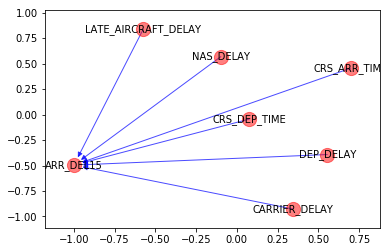

In [9]:
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.5)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.7)
# nx.draw_networkx_edges(bn, pos, edgelist=black_edges, arrows=False)
plt.show()

### NAS Delay

Carrier Delay depends on

In [10]:
nas_delay_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED',\
              'CARRIER_DELAY','WEATHER_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY',]

X = train_df[nas_delay_from]
y = train_df['NAS_DELAY']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NAS_DELAY   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     148.0
Date:                Wed, 28 Mar 2018   Prob (F-statistic):          3.07e-171
Time:                        22:58:58   Log-Likelihood:                -3095.0
No. Observations:                 774   AIC:                             6210.
Df Residuals:                     764   BIC:                             6257.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                -1.7998      0.433     -4.154      0.000      -2.650      -0.949
CRS_DEP_TIME           -0.7293      0.069    -10.580      0.000      -0.865      -0.594
DEP_DELAY               0.6827      0.028     24.303      0.000       0.628       0.738
TAXI_OUT                0.8982      0.043     21.091      0.000       0.815       0.982
TAXI_IN                 0.8631      0.056     15.424      0.000       0.753       0.973
CRS_ARR_TIME           -0.7913      0.078    -10.084      0.000      -0.945      -0.637
DIVERTED            -4.091e-16   2.05e-15     -0.199      0.842   -4.44e-15    3.62e-15
CARRIER_DELAY          -0.6916      0.031    -22.311      0.000      -0.752      -0.631
WEATHER_DELAY          -0.0392      0.698     -0.056      0.955      -1.409       1.331
SECURITY_DELAY         -0.6427      0.235     -2.737      0.006      -1.104      -0.182
LATE_AIRCRAFT_DELAY    -0.7354      0.039    -19.039      0.000      -0.811      -0.660
==============================================================================
Omnibus:                      121.535   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.438
Skew:                           0.905   Prob(JB):                     8.34e-54
Kurtosis:                       5.074   Cond. No.                     1.13e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.59e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [11]:
flights_edges_dict = dict()
for node in nas_delay_from:
    flights_edges_dict[node] = 'NAS_DELAY'
temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
flight_edges_df = flight_edges_df.drop(['index'], axis=1)

## Late Aircraft Delay

OLS with dependent variable WEATHER_DELAY and independent variable DAY_OF_WEEK leads to R-squared value of 0.000.
,
 'ScheduledArrivalPHL' definitely not part of it.

In [12]:
late_aircraft_from = ['MONTH','DEP_DELAY','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY']
X = train_df[late_aircraft_from]
y = train_df['LATE_AIRCRAFT_DELAY']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     LATE_AIRCRAFT_DELAY   R-squared:                       0.741
Model:                             OLS   Adj. R-squared:                  0.739
Method:                  Least Squares   F-statistic:                     439.3
Date:                 Wed, 28 Mar 2018   Prob (F-statistic):          1.55e-222
Time:                         22:58:58   Log-Likelihood:                -2981.5
No. Observations:                  774   AIC:                             5973.
Df Residuals:                      769   BIC:                             5996.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MONTH             0.3373      0.060      5.615      0.000       0.219       0.455
DEP_DELAY         0.6138      0.014     43.512      0.000       0.586       0.641
CARRIER_DELAY    -0.6198      0.019    -33.207      0.000      -0.656      -0.583
WEATHER_DELAY    -0.2071      0.600     -0.345      0.730      -1.385       0.971
NAS_DELAY        -0.2514      0.021    -12.165      0.000      -0.292      -0.211
==============================================================================
Omnibus:                      222.133   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6745.192
Skew:                          -0.628   Prob(JB):                         0.00
Kurtosis:                      17.407   Cond. No.                         92.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
flights_edges_dict = dict()
for node in late_aircraft_from:
    flights_edges_dict[node] = 'LATE_AIRCRAFT_DELAY'
temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
flight_edges_df = flight_edges_df.drop(['index'], axis=1)

In [14]:
[
'QUARTER',
 'MONTH',
 'DAY_OF_WEEK',
 'CRS_DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_DEL15',
 'DIVERTED',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'DelayedDepartureSFO',
 'ScheduledDepartureSFO',
 'DelayedArrivalPHL',
 'ScheduledArrivalPHL'
]

['QUARTER',
 'MONTH',
 'DAY_OF_WEEK',
 'CRS_DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_DEL15',
 'DIVERTED',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'DelayedDepartureSFO',
 'ScheduledDepartureSFO',
 'DelayedArrivalPHL',
 'ScheduledArrivalPHL']

In [15]:
flights_edges_dict = dict()
for node in nas_delay_from:
    flights_edges_dict[node] = 'NAS_DELAY'
temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
flight_edges_df = flight_edges_df.drop(['index'], axis=1)

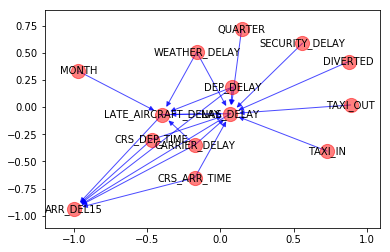

In [16]:
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.5)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.7)
# nx.draw_networkx_edges(bn, pos, edgelist=black_edges, arrows=False)
plt.show()